##Try out models

In [1]:
#code here to establish correct environment
!export PATH=~/anaconda/bin:$PATH

In [2]:
pwd

u'/Users/marjoriesayer/Documents/MIDS/machineLearning/ML_Watchers'

In [9]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import csv
import sys
import xgboost as xgb
# SK-learn libraries for learning.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from utils.data_prep import *


##Obtain Training Data
Put in format for modeling. 

In [10]:
def get_data():
    '''
    Reads data from csv files.
    Does feature engineering with utils.data_prep.assemble functions.
    Makes a dictionary of class weights.
    Creates numpy arrays of data with utils.data_prep.shape functions. 
    :return train_set: numpy array of training data
    :return train_labels: numpy array of training labels
    :return class_weights: dict of class weights.
    :return all_test: numpy array of all kaggle test data. 
    '''
    
    filename = "./data/train.csv"
    testname = "./data/test.csv"

    train_data = assemble_train(filename)
    print train_data.head(3)

    series1 = train_data.groupby("Category").count()["DayOfWeek"]
    #print series1.sort_values(ascending = False)
    #print train_data.columns.values
    def range_fcn(x):
        if x > 100000:
            return 1
        elif x > 10000:
            return 2
        elif x > 1000:
            return 3
        else: return 4
        
    series2 = series1.apply(range_fcn)
    class_weights = dict(series2)
    
    train_set, train_labels = shape_train(train_data)   
    
    #print "class_weights", class_weights
    #for value in train_data.columns.values:
    #    print value
    #    print train_data[value].iloc[:10]
    
    all_test_data = assemble_test(testname)
    # all_test_data.drop('Id', axis=1, inplace=True) # this is a kluge - not working in data_prep
    print "all test data head"
    print all_test_data.head(3)
    
    all_test = shape_test(all_test_data)
    print all_test.shape
        
    return train_set, train_labels, class_weights, all_test

train_set, train_labels, class_weights, all_test = get_data()

                 Dates  Category                  Descript  DayOfWeek  \
0  2015-05-13 23:53:00        37            WARRANT ARREST          2   
1  2015-05-13 23:53:00        21  TRAFFIC VIOLATION ARREST          2   
2  2015-05-13 23:33:00        21  TRAFFIC VIOLATION ARREST          2   

   PdDistrict      Resolution                    Address         X         Y  \
0           4  ARREST, BOOKED         OAK ST / LAGUNA ST -0.107902  0.007832   
1           4  ARREST, BOOKED         OAK ST / LAGUNA ST -0.107902  0.007832   
2           4  ARREST, BOOKED  VANNESS AV / GREENWICH ST -0.057541  0.064335   

   year  month  day  hour  minute  idx  street_1  street_2  
0    15      5   13    23      53   -1         1         2  
1    15      5   13    23      53   -1         1         2  
2    15      5   13    23      33   -1         3         4  
label shape (878049,)
Final Train Columns
   DayOfWeek  PdDistrict         X         Y  year  month  day  hour  minute  \
0          2        

In [11]:
train_set.shape

(878049, 12)

In [16]:
'''
class_weights = {16:1, 21:1, 20:2, 1:2, 7:2, 36:2, 35:2, 37:2, 4:2, 32:2, 19:2, \
                  25:2, 13:2, 12:2, 27:3, 38:3, 23:3, 34:3, 30:3, 28:3, 5:3, 8:3,\
                  24:3, 15:3, 6:3, 26:3, 17:3, 0:3, 18:3, 9:3, 31:4, 11:4, 2:4, 3:4, \
                  10:4, 29:4, 14:4, 22:4, 33:4}
'''


'\nclass_weights = {16:1, 21:1, 20:2, 1:2, 7:2, 36:2, 35:2, 37:2, 4:2, 32:2, 19:2,                   25:2, 13:2, 12:2, 27:3, 38:3, 23:3, 34:3, 30:3, 28:3, 5:3, 8:3,                  24:3, 15:3, 6:3, 26:3, 17:3, 0:3, 18:3, 9:3, 31:4, 11:4, 2:4, 3:4,                   10:4, 29:4, 14:4, 22:4, 33:4}\n'

##Logistic Regression Model

In [17]:
def log_reg_model(trainX, trainY, test, all_test, class_weights):
    '''
    Logistic regression model. Run against reserved test set.
    :param trainX:
    :param trainY:
    :param test: reserved test set for training
    :param all_test: entire test set
    :return:
    '''
    logregr = LogisticRegression(penalty='l2', C=0.05, tol=0.01, class_weight=class_weights)
    logregr.fit(trainX, trainY)
    #weights = logreg.coef_
    dev_predict = logregr.predict(testX)
    probs = logregr.predict_proba(all_test)

    return dev_predict, probs #output the predicted label and model for submittal generation

trainX, trainY = train_set[:600000], train_labels[:600000]
testX, testY = train_set[600000:], train_labels[600000:]

prediction, logreg_probs = log_reg_model(trainX, trainY, testX, all_test, class_weights)

In [18]:
logreg_probs.shape

(884262, 39)

##Random Forest Model

In [23]:
def rf_model(trainX, trainY, testX, all_test): #add all_test to get probs and calc log loss
    '''
    Random Forest model. Run against reserved test set.
    :param trainX:
    :param trainY:
    :param test: reserved test set for training
    :param all_test: entire test set
    :return:
    '''
    randf = RandomForestClassifier()
    randf.fit(trainX, trainY)
    dev_predict = randf.predict(testX)
    probs = randf.predict_proba(all_test)
    return dev_predict, randf #output the predicted label and model for submittal generation

rf_pred, randf_probs = rf_model(trainX, trainY, testX, all_test)

##Gradient Boosted Trees Model

In [ ]:
def xgb_model(trainX, trainY, testX, all_test, rounds=400):
    '''
    xgboost model.
    :param trainX: training set.
    :param trainY: training labels.
    :param testX: reserved test set. 
    :return: prediction of testX and model. 
    '''
    old_params = {'max_depth':15, 'eta':0.3, 'silent':0, 'objective':'multi:softmax', 
         'num_class':3,'min_child':1}
    params = {}
    params["objective"] = "binary:logistic"
    params["eta"] = 0.02
    params["min_child_weight"] = 50
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.8
    params["silent"] = 1
    params["max_depth"] = 5
    params['seed'] = 0
    params['nthread'] = 8
    params['eval_metric'] = 'auc'
    params['scale_pos_weight'] = 1.0
    plst = list(params.items())
    num_rounds = rounds
    dtrain = xgb.DMatrix(trainX, label = trainY)
    dtest = xgb.DMatrix(testX) 
    d_all_test = xgb.DMatrix(all_test)
    
    bst = xgb.train(old_params, dtrain, num_rounds)
    
    prediction = bst.predict(dtest)

##Evaluate Results

In [22]:
labels = {'RECOVERED VEHICLE': 24, 'SUICIDE': 31, 'FRAUD': 13, 'WEAPON LAWS': 38, 'ROBBERY': 25,
          'ARSON': 0, 'SECONDARY CODES': 27, 'SEX OFFENSES FORCIBLE': 28, 'WARRANTS': 37,
          'PROSTITUTION': 23, 'DRUG/NARCOTIC': 7, 'EMBEZZLEMENT': 9, 'TRESPASS': 34, 'LOITERING': 18,
          'KIDNAPPING': 15, 'DRIVING UNDER THE INFLUENCE': 6, 'LARCENY/THEFT': 16, 'VANDALISM': 35,
          'NON-CRIMINAL': 20, 'BURGLARY': 4, 'BAD CHECKS': 2, 'STOLEN PROPERTY': 30, 'EXTORTION': 10,
          'SUSPICIOUS OCC': 32, 'PORNOGRAPHY/OBSCENE MAT': 22, 'LIQUOR LAWS': 17, 'FAMILY OFFENSES': 11,
          'SEX OFFENSES NON FORCIBLE': 29, 'TREA': 33, 'GAMBLING': 14, 'BRIBERY': 3, 'VEHICLE THEFT': 36,
          'FORGERY/COUNTERFEITING': 12, 'ASSAULT': 1, 'DRUNKENNESS': 8, 'MISSING PERSON': 19,
          'DISORDERLY CONDUCT': 5, 'OTHER OFFENSES': 21, 'RUNAWAY': 26}

classnames = dict((v,k) for k,v in labels.iteritems())
names = sorted(labels.keys())
labelvalues = sorted(labels.values())
print names, labelvalues

['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS'] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


In [28]:
def print_confusion_heatmap(cm):
    plt.figure(figsize = (15.0, 10.0))
    plt.imshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def loss_function(probs):
    '''
    Computes the log loss function of a probability matrix. 
    :param probs: numpy array of predicted probabilities
    :param samples: number of samples
    :param num_classes: number of classes (39)
    :param predicted_labels: list of predicted labels (one per sample)
    :param classes: dictionary of classes (gives column to use for row in probs)
    '''
    samples = probs.shape[0]
    num_classes = probs.shape[1]
    logloss = 0
    for i in range(samples):
        p = np.amax(probs[i,:]) # this tells us which probability to take log of
        #p = probs[i, index]
        # to avoid extremes of log function:
        pn = max(min(p,1-10^(-15)),10^(-15))
        newpart = -(np.log(pn))/samples
        logloss += newpart
    return logloss

def error_analysis(predicted, testY, names):
    
    f1_score = metrics.f1_score(predicted, testY, average = None)
    cm = confusion_matrix(testY, predicted)
    #samples = data.shape[0] # number of samples - need for loss fcn
    #probs = model.predict_proba(testX) # predicted probabilities of all classes, all samples
    #num_classes = probs.shape[1] # number of classes, need for loss fcn
    #loss = loss_function(probs, samples, num_classes, labels, classes)

    #print "F1 score: %.5f" % f1_score
    print f1_score
    #print "Cost Function: %.5f" % loss
    print "Classification Report: "
    print(classification_report(testY, predicted, labels=labelvalues, target_names=names))
    print_confusion_heatmap(cm)


/Users/marjoriesayer/envs/xgboost/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/marjoriesayer/envs/xgboost/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[  0.00000000e+00   1.54120267e-01   0.00000000e+00   0.00000000e+00
   3.33583521e-03   0.00000000e+00   0.00000000e+00   1.85527134e-01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.85480094e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.45079817e-01   0.00000000e+00   0.00000000e+00   2.42424242e-04
   1.54981157e-01   2.19389831e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.42389292e-04
   1.72269650e-01   4.52625226e-04   0.00000000e+00]
Classification Report: 
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       486
                    ASSAULT       0.12      0.21      0.15     24310
                 BAD CHECKS       0.00      0.00      0.00       129
                    BRIBE

/Users/marjoriesayer/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


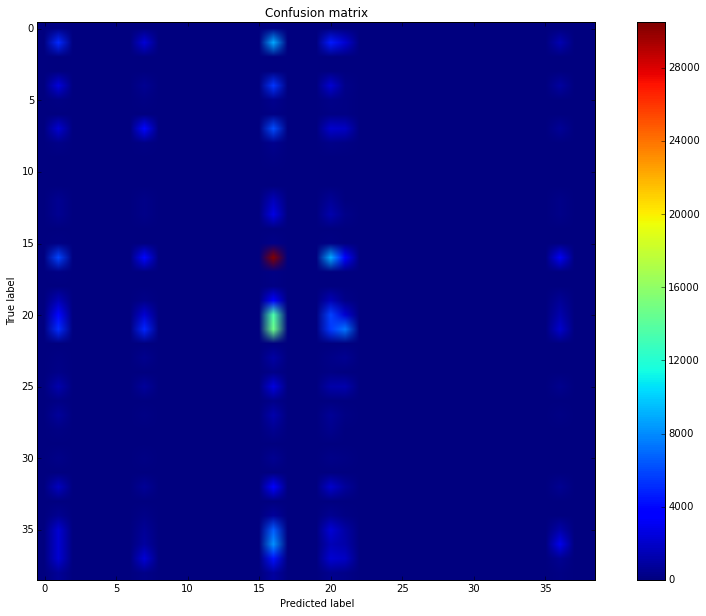

In [23]:
error_analysis(prediction, testY, names)

In [29]:
print loss_function(logreg_probs)

1.9087983223


[ 0.04040404  0.21165002  0.          0.01117318  0.14953912  0.02925198
  0.02854594  0.37549439  0.0041806   0.01845018  0.          0.07843137
  0.13477178  0.08232133  0.08333333  0.02750191  0.46375869  0.06
  0.09917355  0.51795389  0.22240925  0.31167357  0.          0.59660601
  0.03401361  0.05875663  0.21833162  0.00747029  0.15355629  0.
  0.01107595  0.00909091  0.04960372  0.          0.02967033  0.0990108
  0.42390289  0.12504222  0.1325597 ]
Classification Report: 
                             precision    recall  f1-score   support

                      ARSON       0.07      0.03      0.04       486
                    ASSAULT       0.19      0.23      0.21     24310
                 BAD CHECKS       0.00      0.00      0.00       129
                    BRIBERY       0.01      0.01      0.01       104
                   BURGLARY       0.15      0.15      0.15     11774
         DISORDERLY CONDUCT       0.04      0.03      0.03      1395
DRIVING UNDER THE INFLUENCE    

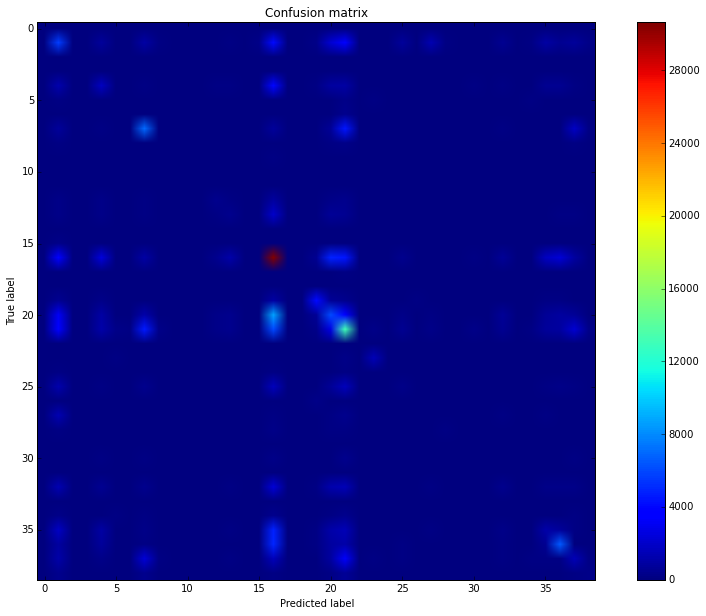

In [24]:
error_analysis(randf, testX, testY, names)